# Análisis de las votaciones de la Cámara de Diputadas y Diputados

## Introducción

En el presente *notebook* se analizarán las votaciones realizadas por la Cámara
de Diputadas y Diputados de Chile en su LVI periodo legislativo (iniciado el
11 de marzo de 2022). La metodología fue inspirada en [FiveThirtyEight](https://projects.fivethirtyeight.com/types-democrats-republicans-house-2024/), quienes realizaron un análisis
similar para la Cámara de Representantes de los Estados Unidos.

Los datos fueron obtenidos mediante [Datos Abiertos Legislativos](https://www.camara.cl/transparencia/datosAbiertos.aspx),
debiéndose procesar los XML con el detalle de cada votación entre el 11 de
marzo de 2022 y la fecha de realización del análisis (13 de octubre de 2024).
La militancia actual de cada diputado también fue extraída de la plataforma. A
cada diputado se le asoció un número por cada votación realizada en el
Congreso: 1 si el diputado aprobó la moción, -1 si la rechazó, y 0 si se
abstuvo. Los valores faltantes (debido a ausencias de los diputados) se
calcularon usando **imputación** mediante KNN.

Luego, se realizó Principal Component Analysis (PCA) sobre la tabla resultante,
para asociar a cada diputado con una coordenada en 2 dimensiones que refleja
sus patrones de voto. Se encontró una clara asociación entre la primera
coordenada del PCA y la posición del diputado en el clásico eje
izquierda-derecha. Usando estos valores, se analizaron las tendencias de los
diputados y sus partidos políticos, incluyendo la cohesión de estos últimos a
la hora de votar.

Finalmente, se realizó un *clustering* utilizando K-Means con $k=5$, obteniendo
5 grupos de diputados que votan de manera similar. Cada grupo fue
posteriormente analizado, concluyendo que los *clusters* calzan con las
principales fuerzas políticas visibles al interior del Congreso.

In [2]:
import xml.etree.ElementTree as ET
import requests

import pickle
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

## Carga de datos

In [212]:
# años para los cuales se tomará información
start_date = datetime.strptime("2022-03-11", "%Y-%m-%d")
end_date = datetime.now()

# prefijo para los sitios de las requests
vote_req_prefix = "https://opendata.camara.cl/camaradiputados/WServices/WSLegislativo.asmx/"
deputy_req_prefix = "https://opendata.camara.cl/camaradiputados/WServices/WSDiputado.asmx/"

# prefijo para las tags de los archivos XML
tag_prefix = r"{http://opendata.camara.cl/camaradiputados/v1}"


# función auxiliar para parsear fechas
def parse_date(date_str):
   return datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S") 

Para cada año de nuestro interés, se obtienen todas las votaciones de ese año.
Para cada votación, buscamos y guardamos la opción por la cual votó cada uno de
los diputados (1 si fue a favor, -1 si fue en contra, 0 si se abstuvo, e
inicialmente `NaN` si no estaba presente).

In [66]:
votes_dict = {}  # diccionario con todas las votaciones

# en orden inverso (porque así está ordenado el XML)
years = range(end_date.year, start_date.year-1, -1)

for year in years:

    # obtenemos lista de votaciones de ese año
    votings_request = requests.get(
        vote_req_prefix + "retornarVotacionesXAnno",
        params={"prmAnno": year}
    )
    votings = ET.fromstring(votings_request.content)

    for voting in votings:
        
        # revisa si la votación está dentro de los límites, la salta si no
        voting_date = parse_date(voting.find(tag_prefix + "Fecha").text)
        if voting_date < start_date or voting_date > end_date:
            continue
        
        voting_id = voting[0].text  # id de la votación
        votes_dict[voting_id] = {}  # dict de la votación actual
        print(f"Procesando votación {voting_id}", end="\r")
        
        # obtenemos detalles de la votación
        voting_detail_request = requests.get(
            vote_req_prefix + "retornarVotacionDetalle",
            params={"prmVotacionId": voting_id}
        )
        voting_detail = ET.fromstring(voting_detail_request.content)
        
        # votos individuales en la votación
        votes = voting_detail.find(tag_prefix + "Votos")
        
        for vote in votes:
            
            deputy_id = vote[0][0].text  # id del diputado
            deputy_choice = vote[1].attrib["Valor"]  # opción por la cual votó
            
            # se agrega al diccionario
            votes_dict[voting_id][deputy_id] = deputy_choice

In [151]:
vote_df = pd.DataFrame(votes_dict)
vote_df = vote_df.astype(float)
vote_df = vote_df.replace(to_replace={0: -1, 2: 0})

vote_df

,43918,43917,43914,43913,43912,43911,43907,43906,43905,43904,...,38482,38481,38478,38477,38476,38475,38474,38469,38468,38467
1171,-1.0,NaN,-1.0,-1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
1121,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1139,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1105,-1.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
976,1.0,1.0,1.0,1.0,-1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,NaN,NaN,1.0,1.0,-1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
989,NaN,NaN,NaN,1.0,-1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0


Ahora, a cada valor nulo le asignamos el promedio de sus 10 vecinos más
cercanos, para no tener que asignarle un valor arbitrario a las ausencias.
Esto se realiza mediante `KNNImputer`.

In [152]:
imputer = KNNImputer(n_neighbors=10)
imputer.set_output(transform="pandas")
vote_df = imputer.fit_transform(vote_df)

vote_df

,43918,43917,43914,43913,43912,43911,43907,43906,43905,43904,...,38482,38481,38478,38477,38476,38475,38474,38469,38468,38467
1171,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
1121,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1139,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1105,-1.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
976,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
989,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1158,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1116,-0.8,0.6,0.3,0.7,-0.3,1.0,1.0,1.0,1.0,1.0,...,-0.6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0


Finalmente, se procesan los diputados con su información relevante, y se
agregan al final de la tabla con los resultados de las votaciones.

In [123]:
deputy_indices = []
deputy_data = []

deputies_request = requests.get(deputy_req_prefix + "retornarDiputados")
deputies = ET.fromstring(deputies_request.content)

for deputy in deputies:
    
    deputy_id = deputy.find(tag_prefix + "Id").text
    
    # caso borde
    if deputy_id == "9999":
        continue
    
    deputy_first_name = deputy.find(tag_prefix + "Nombre").text
    deputy_last_name = deputy.find(tag_prefix + "ApellidoPaterno").text
    deputy_sex = deputy.find(tag_prefix + "Sexo").text

    # último partido al cual ha pertenecido el diputado
    militancies = deputy.find(tag_prefix + "Militancias")
    last_militancy_start = None
    deputy_party = None
    for militancy in militancies:
        
        militancy_start = parse_date(militancy[1].text)
        if (
            last_militancy_start is None
            or militancy_start > last_militancy_start
        ):
            last_militancy_start = militancy_start
            deputy_party = militancy[2][1].text
    
    deputy_indices.append(deputy_id)
    deputy_data.append([
        deputy_first_name,
        deputy_last_name,
        deputy_sex,
        deputy_party
    ])

deputy_df = pd.DataFrame(
    index=deputy_indices,
    columns=["nombre", "apellido", "sexo", "partido"],
    data=deputy_data
)
deputy_df
    

,nombre,apellido,sexo,partido
208,Víctor,Pérez,Masculino,Unión Demócrata Independiente
485,Jorge,Pizarro,Masculino,Partido Demócrata Cristiano
684,Sergio,Pizarro,Masculino,Partido Demócrata Cristiano
696,José Alfonso,Rodríguez,Masculino,Renovación Nacional
951,David,Sandoval,Masculino,Unión Demócrata Independiente
...,...,...,...,...
1106,Miguel Ángel,Becker,Masculino,Renovación Nacional
1118,Ricardo,Cifuentes,Masculino,Partido Demócrata Cristiano
1135,Johannes,Kaiser,Masculino,Independientes
1144,Christian,Matheson,Masculino,Independientes


In [153]:
# juntamos los resultados de las votaciones con la info. de los diputados
vote_df = vote_df.merge(
    right=deputy_df,
    how="left",
    left_index=True,
    right_index=True
)

vote_df


,43918,43917,43914,43913,43912,43911,43907,43906,43905,43904,...,38476,38475,38474,38469,38468,38467,nombre,apellido,sexo,partido
1171,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,-1.0,Emilia,Schneider,Femenino,Frente Amplio
1121,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,Eduardo,Cornejo,Masculino,Unión Demócrata Independiente
1139,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,Enrique,Lee,Masculino,Independientes
1105,-1.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,-1.0,Héctor,Barría,Masculino,Partido Demócrata Cristiano
976,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,Juan Antonio,Coloma,Masculino,Unión Demócrata Independiente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,Marta,Bravo,Femenino,Unión Demócrata Independiente
989,1.0,1.0,1.0,1.0,-1.0,0.9,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,Joaquín,Lavín,Masculino,Unión Demócrata Independiente
1158,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,Víctor Alejandro,Pino,Masculino,Partido Demócratas Chile
1116,-0.8,0.6,0.3,0.7,-0.3,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,-1.0,Felipe,Camaño,Masculino,Independientes


In [253]:
# guardado de datos (para no tener que ejecutar la carga de nuevo)
vote_df.to_pickle("data/vote_df.pkl")

## PCA (Principal Component Analysis)

In [4]:
# cargado de datos
with open("data/vote_df.pkl", 'rb') as file:
    vote_df = pickle.load(file)

Realizamos Principal Component Analysis para reducir el espacio de trabajo a
solo 2 dimensiones y así poder visualizarlo.

Si etiquetamos cada diputado según el partido al cual pertenece, se puede
observar claramente que la primera componente del PCA corresponde a un eje
político izquierda-derecha. La segunda componente no tiene una explicación
tan clara, pero solo explica un 7% de la varianza (versus el 64% que explica
la primera componente), por lo cual su análisis probablemente requiera una
comprensión más profunda sobre las relaciones al interior del Congreso.

En cuanto a la ubicación de cada uno de los diputados, se presentan algunas
observaciones interesantes:
- Aunque pertenece al Partido Comunista, la diputada Cariola tiene patrones
    de votación mucho más similares a aquellos del Frente Amplio.
- El diputado Pino, aunque actualmente pertenece a Demócratas, tiene un
    historial de votación mucho más cercano al bloque de Chile Vamos.
- Los políticos más "de izquierda" pertenecen al Partido Comunista y a Acción
    Humanista, mientras que los más "de derecha" son militantes o están
    asociados al Partido Republicano.
- Todos los partidos políticos con más de un par de diputados parecen estar
    bastante cohesionados en "bloques" definidos.

En relación a este último punto, podemos calcular cuánta "separación" hay al
interior de cada partido, mediante la distancia promedio de los diputados al
centroide del partido al cual pertenecen. Claramente la mayor separación
corresponde a los políticos independientes, pero se puede observar que entre
los partidos con alta separación se encuentran Demócratas (por el diputado
Pino), la DC (probablemente debido al diputado Aedo) y la UDI (que tiene un
espectro bastante amplio en la segunda componente del PCA, con algunos
diputados que se asemejan a RN/Evópoli y otros que se acercan más al cluster
Republicano). Por el contrario, partidos con mayor cohesión son Republicanos,
el Partido Comunista y Acción Humanista.

In [5]:
# dataframe solo con valores numéricos
vote_df_num = vote_df.iloc[:, :-4]

# hacemos PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(vote_df_num)
pca_df = pd.DataFrame(pca_fit, columns=['PCA1', 'PCA2'])

# agregamos columna de partido, nombre y apellido para plottear
pca_df[["nombre", "apellido", "partido"]] = (
    vote_df[["nombre", "apellido", "partido"]]
    .reset_index(drop=True)
)

print("Porcentaje de la varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

Porcentaje de la varianza explicada por cada componente:
[0.64127907 0.07304191]


In [6]:
# código auxiliar para asignar un color (arbitrario) a cada partido político
color_sequence = px.colors.qualitative.Light24
parties = pca_df["partido"].drop_duplicates().sort_values()
color_map = dict(zip(parties, color_sequence))

In [7]:
# plot con la distribución de los diputados en 2 dimensiones

fig = px.scatter(
    pca_df,
    x="PCA1",
    y="PCA2",
    color="partido",
    hover_data=["nombre", "apellido"],
    color_discrete_map=color_map,
    title="Distribución de diputados según PCA"
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)
fig.show()

In [28]:
# ordenamos los diputados según PCA1 y les asignamos su posición en `index`
pca_df_ordered = (
    pca_df.sort_values("PCA1")
    .reset_index()[["PCA1", "partido", "nombre", "apellido"]]
    .reset_index()
)
fig = px.scatter(
    pca_df_ordered,
    x="PCA1",
    y="index",
    color="partido",
    hover_data=["nombre", "apellido"],
    color_discrete_map=color_map,
    title="Diputados según eje izquierda-derecha (componente 1 de PCA)",
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)
fig.show()

In [9]:
# diputados más "extremos"
(pca_df.sort_values("PCA1").reset_index())[
    ["PCA1", "partido", "nombre", "apellido"]
]

,PCA1,partido,nombre,apellido
0,-41.784536,Partido Comunista,Lorena,Pizarro
1,-41.734838,Partido Comunista,Matías,Ramírez
2,-41.694687,Partido Comunista,Nathalie,Castillo
3,-41.591144,Partido Acción Humanista,Tomás,Hirsch
4,-41.533545,Partido Comunista,María Candelaria,Acevedo
...,...,...,...,...
150,42.971491,Partido Republicano,Luis,Sánchez
151,42.986982,Partido Republicano,Juan,Irarrázaval
152,43.005649,Partido Republicano,Benjamín,Moreno
153,43.028973,Partido Republicano,Agustín,Romero


In [10]:
# posición promedio de cada partido
party_means = (
    pca_df.groupby("partido", sort=False)[["PCA1", "PCA2"]]
    .mean()
    .reset_index()
)
fig = px.scatter(
    party_means,
    x="PCA1",
    y="PCA2",
    color="partido",
    color_discrete_map=color_map,
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)
fig.show()

In [11]:
# función para calcular la distancia promedio de los diputados a la media
# de su partido (una forma de ver la dispersión en sus decisiones)
def distance_to_mean(df):
    
    return np.sqrt((np.square(df - df.mean())).sum(axis=1)).mean()

party_distances = (
    vote_df
    .drop(columns=["nombre", "apellido", "sexo"])
    .groupby("partido", sort=False)
    .apply(distance_to_mean)
)
party_distances = (
    party_distances
    .to_frame()
    .reset_index()
    .rename(columns={0: "avg_dist_to_mean"})
    .sort_values(by="avg_dist_to_mean", ascending=False)
)

party_distances

,partido,avg_dist_to_mean
2,Independientes,41.997666
12,Partido Demócratas Chile,23.482063
3,Partido Demócrata Cristiano,20.039613
1,Unión Demócrata Independiente,18.893923
11,Partido Social Cristiano,17.841666
6,Partido Socialista,17.263220
8,Renovación Nacional,16.768582
9,Partido Por la Democracia,14.989334
0,Frente Amplio,13.829228
13,Partido Liberal de Chile,13.297805


## Clustering

Se utilizó K-Means para el clustering, decidiéndose utilizar 5 clusters tras
la realización del método del codo.

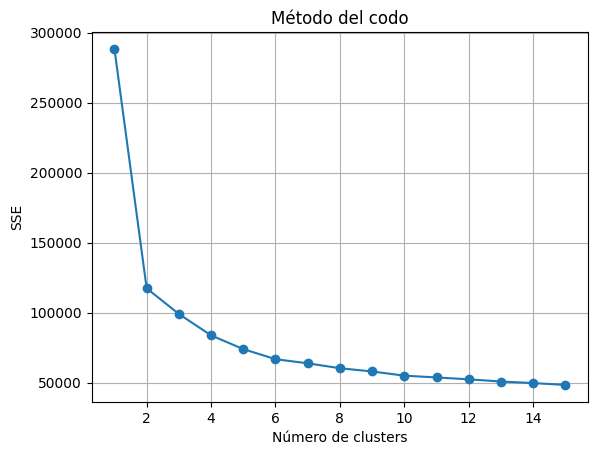

In [12]:
sse = []
clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(vote_df_num)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

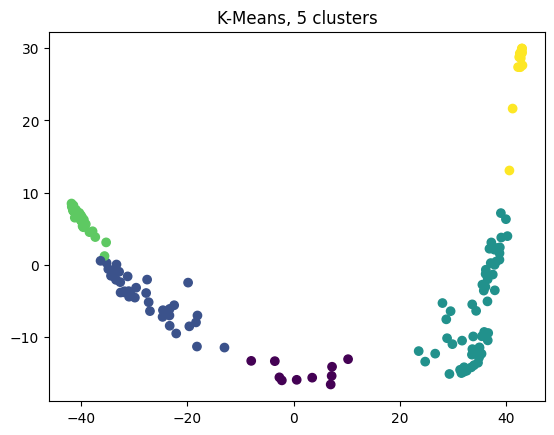

In [13]:
# k-means con 5 clusters
kmeans5 = KMeans(n_clusters=5, n_init=500, random_state=0).fit(vote_df_num)

# plot en 2 dimensiones
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=kmeans5.labels_, cmap='viridis')
plt.title("K-Means, 5 clusters")
plt.show()

## Análisis de clusters

In [14]:
# función auxiliar que retorna un dataframe con todos los diputados que
# pertenecen a un cluster en particular, ordenados por partido y nombre
def list_cluster_deputies(
    cluster_idx,
    cluster_labels=kmeans5.labels_,
    df=vote_df
):
    cluster_deps = df.loc[cluster_labels == cluster_idx]
    cluster_deps = cluster_deps.sort_values(["partido", "apellido", "nombre"])
    return cluster_deps[["nombre", "apellido", "sexo", "partido"]]


# función auxiliar que recibe un índice de cluster, y retorna un dataframe
# donde a cada partido se le asocia el porcentaje de sus diputados que
# pertenecen a dicho cluster
def percentage_of_parties_in_cluster(
    cluster_idx,
    cluster_labels=kmeans5.labels_,
    df=vote_df
):
    
    all_parties = df["partido"].value_counts()
    
    cluster_parties = (
        df.loc[cluster_labels == cluster_idx]["partido"]
        .value_counts()
    )
    
    parties_comp = pd.merge(
        left=all_parties,
        right=cluster_parties,
        how="right",
        left_index=True,
        right_index=True,
        suffixes=("_all", "_cluster")
    )
    parties_comp["porcentaje"] = (
        parties_comp["count_cluster"]
        / parties_comp["count_all"]
    )
    
    return (
        parties_comp["porcentaje"]
        .sort_values(ascending=False)
        .to_frame()
        .reset_index()
        .rename(columns={0: "porcentaje"})
    )

### Cluster 1: Demócratas

El primer cluster está compuesto por 10 diputados:

- 6 diputados independientes (14% del total de independientes). 3 de ellos
(Medina, Oyarzo y Rivas) fueron electos por el Partido de la Gente, pero
posteriormente abandonaron el partido. El diputado Pulgar fue electo en cupo de
Centro Unido pero inmediatamente pasó a formar parte de la bancada del PDG.
- 3 diputados de Demócratas (75% de los diputados del partido). El diputado
    Pino pertenece a Demócratas, pero fue asignado al cluster 3.
- Un diputado de Amarillos (100% de los diputados del partido).

In [15]:
list_cluster_deputies(0)

,nombre,apellido,sexo,partido
1016,Miguel Ángel,Calisto,Masculino,Independientes
1116,Felipe,Camaño,Masculino,Independientes
1145,Karen,Medina,Femenino,Independientes
1155,Rubén Darío,Oyarzo,Masculino,Independientes
1161,Francisco,Pulgar,Masculino,Independientes
948,Gaspar,Rivas,Masculino,Independientes
1134,Andrés,Jouannet,Masculino,Movimiento Amarillos por Chile
1057,Erika,Olivera,Femenino,Partido Demócratas Chile
1062,Joanna,Pérez,Femenino,Partido Demócratas Chile
1168,Jorge,Saffirio,Masculino,Partido Demócratas Chile


In [16]:
percentage_of_parties_in_cluster(0)

,partido,porcentaje
0,Movimiento Amarillos por Chile,1.000000
1,Partido Demócratas Chile,0.750000
2,Independientes,0.142857


### Cluster 2: Socialismo Democrático

El segundo cluster está compuesto por 37 diputados, pertenencientes en su gran
mayoría al Socialismo Democrático:

- 12 diputados independientes (29% del total de independientes). La mayoría
fueron electos como independientes en cupos del Socialismo Democrático.
- 12 diputados del Partido Socialista (100% de los diputados del partido).
- 4 diputados de la Democracia Cristiana (100% de los diputados del partido).
- 3 diputados del Partido Liberal (100% de los diputados del partido).
- 3 diputados del PPD (100% de los diputados del partido).
- 2 diputados del Partido Radical (100% de los diputados del partido).
- Una diputada del Partido Humanista (100% de los diputados del partido).

In [17]:
list_cluster_deputies(1)

,nombre,apellido,sexo,partido
803,René,Alinco,Masculino,Independientes
1099,Jaime,Araya,Masculino,Independientes
1101,Mónica,Arce,Femenino,Independientes
1110,Carlos,Bianchi,Masculino,Independientes
1124,Tomás,De Rementería,Masculino,Independientes
1125,Viviana,Delgado,Femenino,Independientes
1130,Marta,González,Femenino,Independientes
1137,Tomás,Lagomarsino,Masculino,Independientes
1151,Camila,Musante,Femenino,Independientes
1175,Cristián,Tapia,Masculino,Independientes


In [18]:
percentage_of_parties_in_cluster(1)

,partido,porcentaje
0,Partido Socialista,1.000000
1,Partido Demócrata Cristiano,1.000000
2,Partido Por la Democracia,1.000000
3,Partido Liberal de Chile,1.000000
4,Partido Radical de Chile,1.000000
5,Partido Humanista,1.000000
6,Independientes,0.285714


### Cluster 3: Chile Vamos

El tercer cluster es el más grande, y está compuesto por 55 diputados,
pertenencientes en su gran mayoría a Chile Vamos:

- 20 diputados de la UDI (100% de los diputados del partido).
- 17 diputados de Renovación Nacional (100% de los diputados del partido).
- 12 diputados independientes (24% del total de independientes). La mayoría
fueron electos como independientes en cupos de Chile Vamos.
- 3 diputados del Partido Social Cristiano (100% de los diputados del partido).
- 2 diputados de Evópoli (100% de los diputados del partido).
- Un diputado de Demócratas (25% de los diputados del partido). Corresponde al
    diputado Pino antes mencionado.

In [19]:
list_cluster_deputies(2)

,nombre,apellido,sexo,partido
1132,Jorge,Guzmán,Masculino,Evolución Política
1081,Francisco,Undurraga,Masculino,Evolución Política
1098,Yovana,Ahumada,Femenino,Independientes
971,Bernardo,Berger,Masculino,Independientes
1022,Sofía,Cid,Femenino,Independientes
1120,María Luisa,Cordero,Femenino,Independientes
1025,Catalina,Del Real,Femenino,Independientes
1136,Paula,Labra,Femenino,Independientes
1139,Enrique,Lee,Masculino,Independientes
1144,Christian,Matheson,Masculino,Independientes


In [20]:
percentage_of_parties_in_cluster(2)

,partido,porcentaje
0,Unión Demócrata Independiente,1.000000
1,Renovación Nacional,1.000000
2,Partido Social Cristiano,1.000000
3,Evolución Política,1.000000
4,Independientes,0.285714
5,Partido Demócratas Chile,0.250000


### Cluster 4: Frente Amplio/Chile Digno

El cuarto cluster está compuesto por 38 diputados, pertenencientes en su
gran mayoría al Frente Amplio y Chile Digno:

- 20 diputados del Frente Amplio (100% de los diputados del partido)
- 10 diputados del Partido Comunista (100% de los diputados del partido)
- 5 diputados independientes (12% del total de independientes). Dos de ellos
(Delgado y González) fueron electos por el PEV, que posteriormente se disolvió.
- 2 diputados de Acción Humanista (100% de los diputados del partido).
- Un diputado del FREVS (100% de los diputados del partido).

In [21]:
list_cluster_deputies(3)

,nombre,apellido,sexo,partido
872,Jaime,Mulet,Masculino,Federación Regionalista Verde Social
1107,María Francisca,Bello,Femenino,Frente Amplio
1015,Jorge,Brito,Masculino,Frente Amplio
1114,Félix,Bugueño,Masculino,Frente Amplio
1127,Lorena,Fries,Femenino,Frente Amplio
1129,Andrés,Giordano,Masculino,Frente Amplio
1037,Diego,Ibáñez,Masculino,Frente Amplio
1051,Claudia,Mix,Femenino,Frente Amplio
1148,Javiera,Morales,Femenino,Frente Amplio
1058,Maite,Orsini,Femenino,Frente Amplio


In [22]:
percentage_of_parties_in_cluster(3)

,partido,porcentaje
0,Frente Amplio,1.000000
1,Partido Comunista,1.000000
2,Partido Acción Humanista,1.000000
3,Federación Regionalista Verde Social,1.000000
4,Independientes,0.119048


### Cluster 5: Republicanos

El quinto y último cluster está compuesto por 15 diputados:

- 8 diputados del Partido Republicano (100% de los diputados del partido)
- 7 diputados independientes (17% del total de independientes). Todos están
asociados al Partido Republicano (fueron electos como independientes en cupos
de Republicanos, o fueron electos mientras pertenecían al partido y luego
fueron expulsados o renunciaron).

In [24]:
list_cluster_deputies(4)

,nombre,apellido,sexo,partido
1123,Gonzalo,De la Carrera,Masculino,Independientes
1040,Harry,Jürgensen,Masculino,Independientes
1135,Johannes,Kaiser,Masculino,Independientes
1152,Gloria,Naveillan,Femenino,Independientes
1154,Mauricio,Ojeda,Masculino,Independientes
1069,Leonidas,Romero,Masculino,Independientes
1172,Stephan,Schubert,Masculino,Independientes
1100,Cristián,Araya,Masculino,Partido Republicano
1104,Chiara,Barchiesi,Femenino,Partido Republicano
1133,Juan,Irarrázaval,Masculino,Partido Republicano


In [25]:
percentage_of_parties_in_cluster(4)

,partido,porcentaje
0,Partido Republicano,1.000000
1,Independientes,0.166667
